# 1. Загрузка данных, задание функций

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid') #, {'grid.color': '.1', 'text.color': '.1', 'text.size' : '40'})
sns.set(font_scale=1)

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as MAE , mean_squared_error as MSE
from sklearn.externals import joblib

import lightgbm as lgb
from lightgbm import LGBMRegressor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Задаем функции

In [2]:
# Функция для расчета и вывода метрик
def metrics(y_true, y_predict):
  mae_score = MAE(y_true, y_predict)
  mse_score = MSE(y_true, y_predict)
  print('MAE = {}'.format(round(mae_score,2)))
  print('MSE = {}'.format(round(mse_score,2)))
  return mae_score, mse_score

In [3]:
# Визуализация соотношения y_true / y_predict 

def true_predict_ratio(y_true_train, y_predict_train, 
                       y_true_test, y_predict_test, hue, xy_max):
  if xy_max == None:
    xy_max = max(y_true_train.max(), y_true_test.max(), y_predict_train.max(), y_predict_test.max())
  
  
  fig, ax = plt.subplots(1,2, figsize = (12,6))
  
  sns.scatterplot(x = y_true_train, y = y_predict_train, ax = ax[0])
  ax[0].set_title('TRAIN')
  ax[0].set_xlabel('y_true_train')
  ax[0].set_ylabel('y_predict_train')
  ax[0].set_xlim([-10, xy_max + 10])
  ax[0].set_ylim([-10, xy_max + 10])
  
  try:
    sns.scatterplot(x = y_true_test.values, y = y_predict_test, ax = ax[1], hue = hue.values)
  except:
    sns.scatterplot(x = y_true_test.values, y = y_predict_test, ax = ax[1])
  ax[1].set_title('TEST')
  ax[1].set_xlabel('y_true_test')
  ax[1].set_ylabel('y_predict_test')
  ax[1].set_xlim([-10, xy_max + 10])
  ax[1].set_ylim([-10, xy_max + 10])

In [4]:
# Визуализация важности признаков обученной модели

def importance_visualisation(model_fitted, cols):
  try:
    importances = pd.Series(data = abs(model_fitted.feature_importances_), index = list(cols))
  except:
    importances = pd.Series(data = abs(model_fitted.best_estimator_.feature_importances_), index = list(cols))

  importances = importances.sort_values(ascending = False)
  plt.figure(figsize = (10,4))
  sns.barplot(x = list(importances.index) , y = importances)
  plt.xticks(rotation = 90)
  plt.title('Значимость признаков')
  plt.show()

In [5]:
# Визуализация предсказаний для новых позиций, которые отсутствуют в обучающей выборке
def true_predict_visual_uniq(y_true, y_predict, train_set):
  
  hues = list(train_set.columns)
  fig, ax = plt.subplots(len(hues), 1,  figsize=(6, 6 * len(hues)))
  ax_lim = np.array(list(y_true) + list(y_predict)).max()
  i = 0
  for i in range(len(hues)):
    if hues[i] == 'body':
      sns.scatterplot(x = y_true, y = y_predict, 
                    hue = train_set[hues[i]].replace(dict((v,k) for k, v in dict_body_num.items())).values, ax = ax[i])
    elif hues[i] == 'size':
      sns.scatterplot(x = y_true, y = y_predict, 
                    hue = train_set[hues[i]].replace(dict(zip((train_set['size'].unique()) , 
                                                          [str(value) for value in X['size'].unique()]))).values, ax = ax[i])
      
    else:
      sns.scatterplot(x = y_true, y = y_predict, hue = train_set[hues[i]].values, ax = ax[i])
    ax[i].set_title(hues[i])
    ax[i].set_xlabel('y_true_test')
    ax[i].set_ylabel('y_predict_test')
    ax[i].set_xlim([-10, ax_lim + 10])
    ax[i].set_ylim([-10, ax_lim + 10])  

Загружаем данные

In [6]:
total_spec = pd.read_excel('spec_work.xlsx', index_col = 0)
total_spec

,valve_type,size,class_rating,body,connection,actuator,trim,seat,face_to_face,weight,specification,usd_unit_price
0,GLOBE VALVE TO API623,150,300,A352 LCC,FLANGED,H / L,316_HF,METAL,445,173.0,ner_ggc,1857.16
1,GATE VALVE,20,600,A182 F316,FLANGED,H / L,316_HF,METAL,191,5.6,kfap,192.00
2,GLOBE VALVE,50,150,A350 LF2,FLANGED,H / L,316_HF,METAL,203,21.0,kfap,146.00
3,GATE VALVE,25,300,A182 F316,FLANGED,H / L,316_HF,METAL,165,12.5,kfap,208.00
4,SWING CHECK VALVE,80,300,A216 WCB,FLANGED,NO,316_HF,METAL,318,40.0,kfap,195.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1657,SWING CHECK VALVE,150,300,A216 WCB,FLANGED,NO,316_HF,METAL,445,118.0,kfap,497.00
1658,SWING CHECK VALVE,80,300,A216 WCB,FLANGED,NO,316_HF,METAL,318,40.0,kfap,195.00
1659,GLOBE VALVE,150,300,A216 WCB,FLANGED,H / L,316_HF,METAL,445,173.0,kfap,863.00
1660,GLOBE VALVE,80,150,A216 WCB,FLANGED,H / L,316_HF,METAL,241,35.0,kfap,243.00


# Замечания
1. В датасете указаны наиболее важные признаки исходя из практического опыта работы в данной сфере.
2. Признаки face_to_face (строительная длина) и weight  (вес) созданы самостоятельно из справочных материалов.  Как будет показано ниже эти признаки дали очень большую корреляцию с целевым признаком и существенно улучшают качество модели.
3. Признак specification - название конкретного заказа, для которого сформированы цены. Дело в том что для каждого заказа могут быть разные скидки и соответсвенно разные цены для одних и тех же позиций

# 2. EDA анализ

## 2.1 Valve_type

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

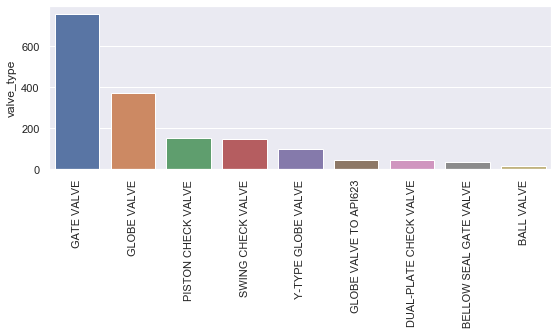

In [7]:
plt.figure(figsize = (9,3))
sns.barplot(x = list(total_spec['valve_type'].value_counts().index), y = total_spec['valve_type'].value_counts())
plt.xticks(rotation=90)

## SIZE

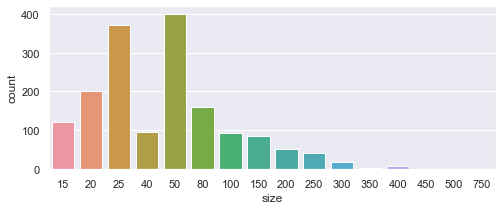

In [8]:
plt.figure(figsize = (8,3))
sns.countplot(total_spec['size'])

## 2.3 Class rating

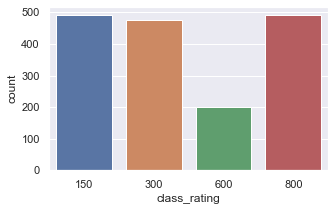

In [9]:
plt.figure(figsize = (5,3))
sns.countplot(total_spec['class_rating'])

## 2.4 BODY

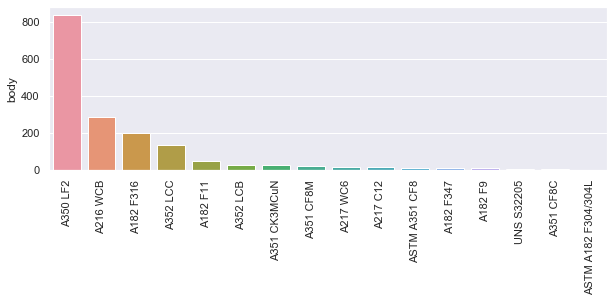

In [10]:
plt.figure(figsize = (10,3))
sns.barplot(x = list(total_spec['body'].value_counts().index), y = total_spec['body'].value_counts())
plt.xticks(rotation=90)
plt.show()

Некоторые материалы являются аналогами (отличаются технологией получения - литье или поковка). Можем их объединить

In [11]:
dict_body = {
    'A216 WCB' : 'WCB',
    'A350 LF2' : 'LF2_LCB_LCC', 'A352 LCC' : 'LF2_LCB_LCC', 'A352 LCB' : 'LF2_LCB_LCC',


    'A182 F11' : 'F11_WC6', 'A217 WC6' : 'F11_WC6', 
    'A182 F9' : 'F9_C12', 'A217 C12' : 'F9_C12',
    'A182 F316' : 'F316_CF8M', 'A351 CF8M' : 'F316_CF8M',
    'A182 F321' : 'F321',
    'A182 F347' : 'F347_CF8C', 'A351 CF8C' : 'F347_CF8C',
    'ASTM A351 CF8' : 'F304_CF8', 'ASTM A182 F304/304L' : 'F304_CF8'
}

In [12]:
total_spec['body'] = total_spec['body'].replace(dict_body)

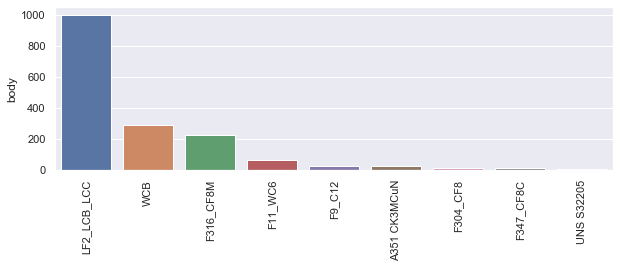

In [13]:
plt.figure(figsize = (10,3))
sns.barplot(x = list(total_spec['body'].value_counts().index), y = total_spec['body'].value_counts())
plt.xticks(rotation=90)
plt.show()

In [14]:
total_spec['body'].unique()

array(['LF2_LCB_LCC', 'F316_CF8M', 'WCB', 'F11_WC6', 'A351 CK3MCuN',
       'F304_CF8', 'F9_C12', 'F347_CF8C', 'UNS S32205'], dtype=object)

## 2.4 connection

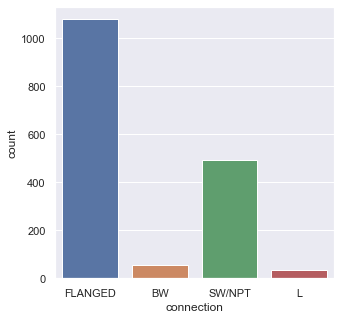

In [15]:
plt.figure(figsize = (5,5))
sns.countplot(total_spec['connection'])

## 2.5 actuator

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

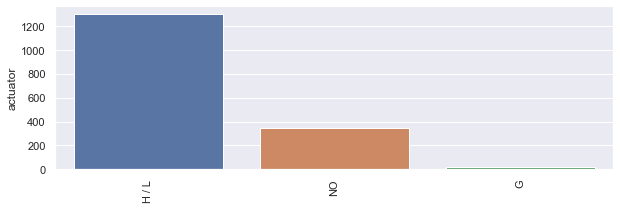

In [16]:
plt.figure(figsize = (10,3))
sns.barplot(x = list(total_spec['actuator'].value_counts().index), y = total_spec['actuator'].value_counts())
plt.xticks(rotation=90)

## 2.6 TRIM

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

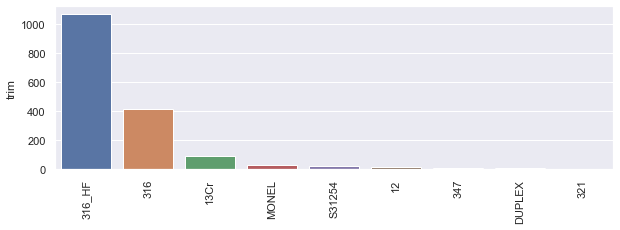

In [17]:
plt.figure(figsize = (10,3))
sns.barplot(x = list(total_spec['trim'].value_counts().index), y = total_spec['trim'].value_counts())
plt.xticks(rotation=90)

## 2.7 face_to_face

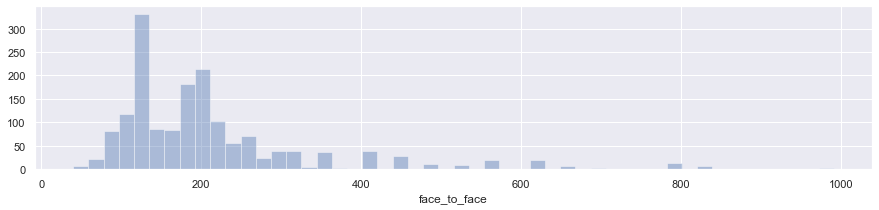

In [18]:
plt.figure(figsize = (15,3))
sns.distplot(total_spec['face_to_face'], kde = False)
plt.show()

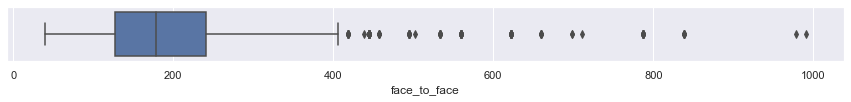

In [19]:
plt.figure(figsize = (15,1))
sns.boxplot(total_spec['face_to_face'])
plt.show()

## 2.8 weight

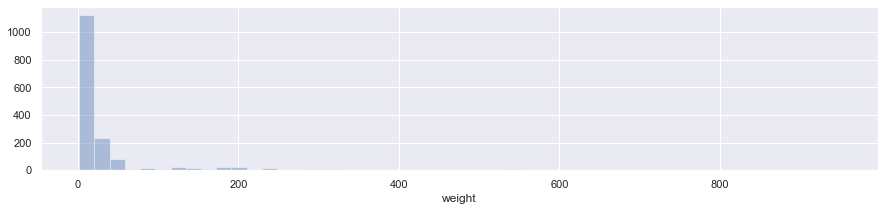

In [20]:
plt.figure(figsize = (15,3))
sns.distplot(total_spec['weight'], kde = False)
plt.show()

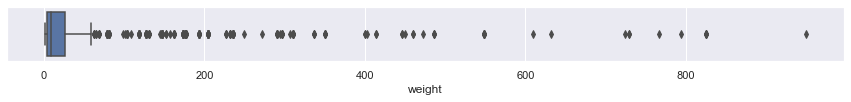

In [21]:
plt.figure(figsize = (15,1))
sns.boxplot(total_spec['weight'])
plt.show()

## 2.9 usd_unit_price

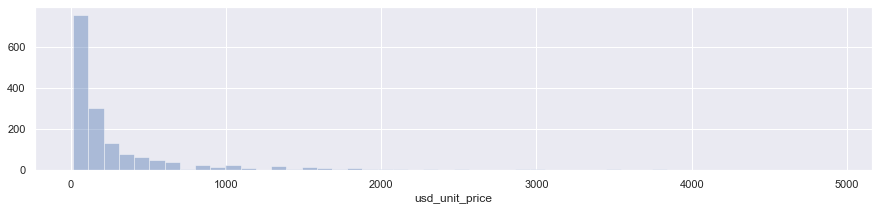

In [22]:
plt.figure(figsize = (15,3))
sns.distplot(total_spec['usd_unit_price'], kde = False)
plt.show()

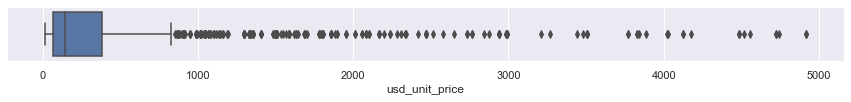

In [23]:
plt.figure(figsize = (15,1))
sns.boxplot(total_spec['usd_unit_price'])
plt.show()

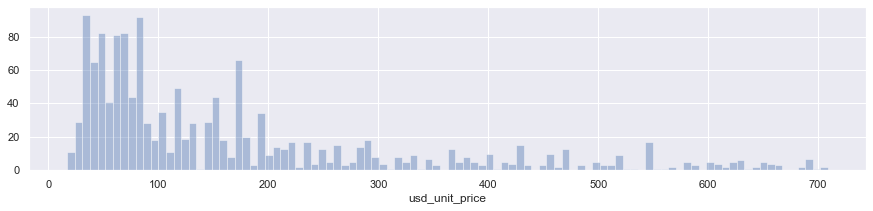

In [24]:
plt.figure(figsize = (15,3))
sns.distplot(total_spec[total_spec['usd_unit_price'] < 750]['usd_unit_price'], bins = 100, kde = False)
plt.show()

In [25]:
total_spec['usd_unit_price'].mean()

400.1490734055357

In [26]:
total_spec['usd_unit_price'].median()

146.0

## 2.10 Корреляционный анализ

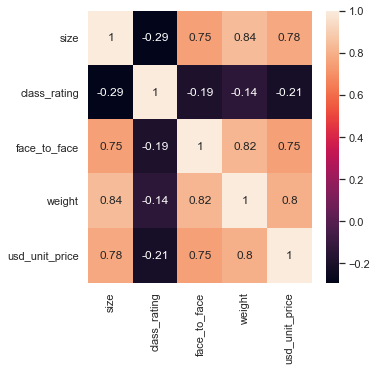

In [27]:
plt.figure(figsize=(5,5))
sns.heatmap(total_spec.corr(), annot=True)

### Видим:
1. Высокую корреляцию weight и face_to_face с целевым признаком.  Напоминаю что изначально в реальной работе этих признаков не было, мы их создали самостоятельно по справочной информации (есть в отрытом доступе в интернете)
2. Обратная корреляция между class_rating и целевым признаком.   ЭТо НЕ СООТВЕТСТВУЕТ ДЕЙСТВИТЕЛЬНОСТИ, на самом деле чем выше class_rating  тем выше цена. Данное явление мы наблюдаем, потому что в нашем датасете высокий class_rating для позиций с маленьким размером и соответственно маленькими признаками size, face_to_face, weight и соответственно маленький class_rating у позиций с высоким  size, face_to_face, weight.  Получается влияние других признаков перекрывает и скрывает от нас  реальную зависимость между class_rating и ценой

<Figure size 576x576 with 0 Axes>

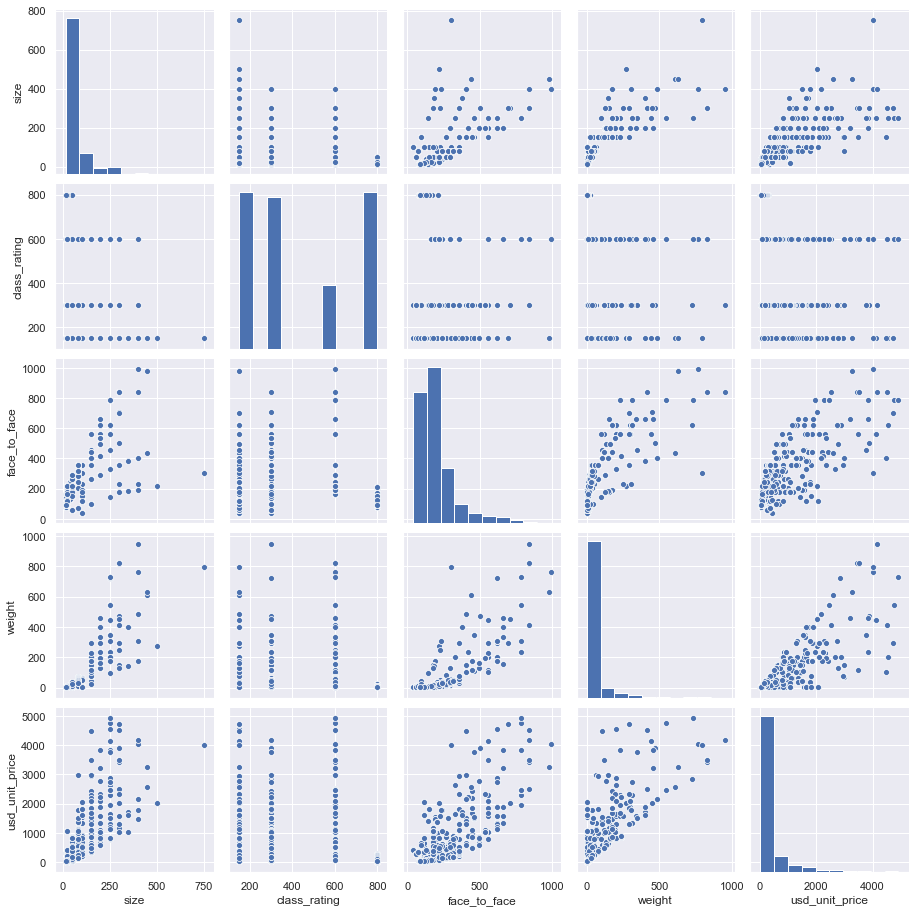

In [28]:
plt.figure(figsize=(8,8))
sns.pairplot(total_spec)

## 2.1 Уникальность данных  
Посмотрим сколько у нас уникальных позиций

In [29]:
total_spec.shape

(1662, 12)

In [30]:
total_spec.drop_duplicates().shape

(433, 12)

In [31]:
total_spec.drop_duplicates().shape[0] / total_spec.shape[0]

0.2605294825511432

Видим что у нас только 26% из всего дадасета являются уникальными.  Я не рекомендую удалять дубликаты т.к.:
1. Они получены из реальной жизни и их распределение соответствует реальной ситуации
2. У нас большой разбег по значению целевого признака - есть очень дешевые и очень дорогие позиции.  Большинство дубликатов у позиций с маленькой ценой, поэтому есть смысл их оставить т.к. при обучении модели и минимазции MSE  дешевые позиции за счет своего количества будут  учтены в справедливом соотношении с дорогими позициями 

# 3. Подготовка данных к обучению моделей

## 3.1 Первым делом стоит перевести body (материал корпуса клапана) в численный тип данных. Т.к. есть понимание какой материал дороже а какой дешевле. Для наглядности создадим новый числовой столбец и сохраним старый категориальный а потом посмотрим на важность признаков в моделях

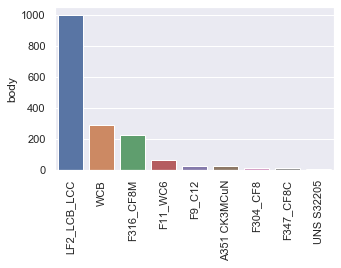

In [32]:
plt.figure(figsize = (5,3))
sns.barplot(x = list(total_spec['body'].value_counts().index), y = total_spec['body'].value_counts())
plt.xticks(rotation=90)
plt.show()

## Коэффициенты для материалов корпуса подобраны из собственного опыта, анализа данного датасета, а также данного источника   
https://ru.scribd.com/doc/237305322/Material-Reference-Chart

In [33]:
dict_body_num = {
    'A216 WCB' : 3, 'WCB' : 3,
    'A350 LF2' : 4, 'A352 LCC' : 4, 'A352 LCB' : 4, 'LF2_LCB_LCC' : 4,
    'A182 F11' : 5, 'A217 WC6' : 5,  'F11_WC6' : 5,
    'A182 F9' : 6, 'A217 C12' : 6, 'F9_C12' : 6,
    'F304_CF8' : 8,
    'A182 F316' : 9, 'A351 CF8M' : 9, 'F316_CF8M' : 9,
    'A182 F321' : 10, 'F321' : 10,
    'A182 F347' : 11, 'A351 CF8C' : 11, 'F347_CF8C' : 11,
    
    'A351 CK3MCuN': 14,
    'UNS S32205': 14,

    'B381 F2' : 140
}

In [34]:
total_spec['body_num'] = total_spec['body'].replace(dict_body_num)

total_spec = total_spec.loc[:, ['valve_type', 'size', 'class_rating', 'body', 'connection', 'actuator',
       'trim', 'seat', 'face_to_face', 'weight', 'specification', 'body_num',
       'usd_unit_price']]

In [35]:
total_spec['body_num'].unique()

array([ 4,  9,  3,  5, 14,  8,  6, 11], dtype=int64)

Проверим наше предположение посмотрев на корреляцию

In [36]:
total_spec[['body_num', 'usd_unit_price']].corr()

,body_num,usd_unit_price
body_num,1.000000,0.053097
usd_unit_price,0.053097,1.000000


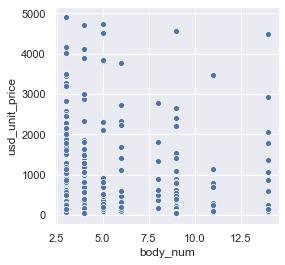

In [37]:
plt.figure(figsize = (4,4))
sns.scatterplot(x = total_spec['body_num'], y = total_spec['usd_unit_price'])
plt.show()

Видим что корреляции нет, но возможно ситуация аналогична признаку pressure_class. Посмотрим на ыважность признаков после обучения моделей

## 3.2 Отделение целевого признака. Выделение количественных и категориальных признаков

In [38]:
X = total_spec.drop(columns = ['usd_unit_price'])
y = total_spec['usd_unit_price']

In [39]:
X.dtypes

valve_type        object
size               int64
class_rating       int64
body              object
connection        object
actuator          object
trim              object
seat              object
face_to_face       int64
weight           float64
specification     object
body_num           int64
dtype: object

In [40]:
num_features = list(X.columns[[col != 'object' for col in X.dtypes]])
cat_features = list(X.columns[[col == 'object' for col in X.dtypes]])

In [41]:
num_features

['size', 'class_rating', 'face_to_face', 'weight', 'body_num']

In [42]:
cat_features

['valve_type',
 'body',
 'connection',
 'actuator',
 'trim',
 'seat',
 'specification']

Дальше будет следующая последовательность:  
1. Обработка категориальных признаков, потому что если сначала сделать разделение на обучающую и тестовую выборки то есть риск что не все варианты категориальных признаков попадут в каждую из выборок.  
2. Разделение на обучающую и валидационную выборки.  
3. Нормализация числовых признаках - тут уже нужно отдельно обрабатывать обучающую и валидационную выборки

## 3.3  Ordinal преобразование

In [43]:
X_ord = X.copy()
X_ord[cat_features] = X_ord[cat_features].fillna("nan_value")
X_ord[cat_features] = pd.DataFrame(OrdinalEncoder().fit_transform(X_ord[cat_features]), columns = cat_features)
X_ord[cat_features] = X_ord[cat_features].astype(int)

X_ord

,valve_type,size,class_rating,body,connection,actuator,trim,seat,face_to_face,weight,specification,body_num
0,5,150,300,6,1,1,3,0,445,173.0,4,4
1,3,20,600,3,1,1,3,0,191,5.6,0,9
2,4,50,150,6,1,1,3,0,203,21.0,0,4
3,3,25,300,3,1,1,3,0,165,12.5,0,9
4,7,80,300,8,1,2,3,0,318,40.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1657,7,150,300,8,1,2,3,0,445,118.0,0,3
1658,7,80,300,8,1,2,3,0,318,40.0,0,3
1659,4,150,300,8,1,1,3,0,445,173.0,0,3
1660,4,80,150,8,1,1,3,0,241,35.0,0,3


## 3.5 Разделение на train и eval

In [44]:
total_spec_train, total_spec_eval, \
X_train, X_eval,  \
X_ord_train, X_ord_eval,  \
y_train, y_eval = train_test_split(total_spec , X, X_ord, y, test_size = 0.1, shuffle=True)  # , random_state = 42  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## 3.6 Выделение уникальных позиций в eval относительно train

In [45]:
# список названий столбцов-признаков
key_col = list(total_spec_eval.columns)

# добавляем новый столбец с индексами в тестовую выборку
spec_eval_idx = total_spec_eval.reset_index()

# Список индексов позиций тестовой выборки, которые не встречаются в обучающей выборке
duplicate_index = pd.merge(total_spec_train, spec_eval_idx, how= 'inner', on=key_col)['index'].unique()

# создаем тестовую выборку, в которой есть только новые по отношению к обучающей выборке позиции
unique_spec_eval = spec_eval_idx[~spec_eval_idx['index'].isin(duplicate_index)].drop(columns = ['index'])
unique_spec_eval.head(2)

,valve_type,size,class_rating,body,connection,actuator,trim,seat,face_to_face,weight,specification,body_num,usd_unit_price
0,SWING CHECK VALVE,80,300,LF2_LCB_LCC,FLANGED,NO,316_HF,METAL,318,40.0,kfap,4,273.0
14,PISTON CHECK VALVE,20,800,LF2_LCB_LCC,SW/NPT,NO,316_HF,METAL,110,2.6,kfap,4,19.0


In [46]:
print('Количество НОВЫХ строк в eval = {}'.format(len(unique_spec_eval)))
print('Доля НОВЫХ строк в eval относительно размера eval  =  {:.2%}'.format(len(unique_spec_eval) / len(total_spec_eval)))
print('Доля НОВЫХ строк в eval относительно всего датасета =  {:.2%}'.format(len(unique_spec_eval) / len(total_spec)))

Количество НОВЫХ строк в eval = 25
Доля НОВЫХ строк в eval относительно размера eval  =  14.97%
Доля НОВЫХ строк в eval относительно всего датасета =  1.50%


In [47]:
# Создаем объект series который будем использовать при визуализации предсказаний для новых по отношению к train позиций
hue_for_eval = spec_eval_idx['index'].isin(duplicate_index).replace({True : 'ЕСТЬ В TRAIN', False : 'НОВАЯ ПОЗИЦИЯ'})
hue_for_eval

0      НОВАЯ ПОЗИЦИЯ
1       ЕСТЬ В TRAIN
2       ЕСТЬ В TRAIN
3       ЕСТЬ В TRAIN
4       ЕСТЬ В TRAIN
           ...      
162     ЕСТЬ В TRAIN
163    НОВАЯ ПОЗИЦИЯ
164     ЕСТЬ В TRAIN
165     ЕСТЬ В TRAIN
166     ЕСТЬ В TRAIN
Name: index, Length: 167, dtype: object

Создадим выборку ТОЛЬКО с позициями, которые не встречаются в train

In [48]:
total_spec_eval_uniq = total_spec_eval[~total_spec_eval.index.isin(duplicate_index)]
X_eval_uniq =  X_eval[~ X_eval.index.isin(duplicate_index)]
X_ord_eval_uniq =  X_ord_eval[~X_ord_eval.index.isin(duplicate_index)]
y_eval_uniq =   y_eval[~y_eval.index.isin(duplicate_index)]

## 3.7 Стандартизация

In [49]:
scaler = StandardScaler()

X_st_train = X_train.copy()
X_st = X.copy()
X_st_eval = X_eval.copy()
X_st_eval_uniq = X_eval_uniq.copy()
X_st_train[num_features] = scaler.fit_transform(X_st_train[num_features])
X_st[num_features] = scaler.transform(X_st[num_features])
X_st_eval[num_features] = scaler.transform(X_st_eval[num_features])
X_st_eval_uniq[num_features] = scaler.transform(X_st_eval_uniq[num_features])

X_ord_st_train = X_ord_train.copy()
X_ord_st = X_ord.copy()
X_ord_st_eval = X_ord_eval.copy()
X_ord_st_eval_uniq = X_ord_eval_uniq.copy()
X_ord_st_train[num_features] = scaler.fit_transform(X_ord_st_train[num_features])
X_ord_st[num_features] = scaler.transform(X_ord_st[num_features])
X_ord_st_eval[num_features] = scaler.transform(X_ord_st_eval[num_features])
X_ord_st_eval_uniq[num_features] = scaler.transform(X_ord_st_eval_uniq[num_features])

## 5 Обучаем нашу модель lgbm + randomsearch

In [50]:
%%time

pg_random_search = {'boosting_type' : ['gbdt'],
            'num_leaves': list(range(5,51,5)),
            'max_depth':  list(range(7,10,1)),
             'n_estimators' : [200, 500, 800, 1000],
             'min_data_in_leaf': list(range(1,10,1))}
    
model_lgbm = RandomizedSearchCV(estimator= LGBMRegressor( objective= 'regression', verbose = 50), scoring = 'neg_mean_squared_error', 
                               param_distributions= pg_random_search, 
                               n_iter = 100, n_jobs=-1, verbose = 50, cv = 3)
# Обучаем модель
model_lgbm.fit(X_ord_st_train, y_train, categorical_feature = cat_features)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   55.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.6min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Wall time: 1min 44s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective='regression',
                                           random_state=None, reg_alpha=0.0,
                                           reg_lambda=0...
                                           subsample_freq=0, verbose=50),
                   iid='deprecated', n_iter=100, n_jobs=-1,
   

In [51]:
# смотрим лучшие гиперпараметры
model_lgbm.best_params_

{'num_leaves': 5,
 'n_estimators': 1000,
 'min_data_in_leaf': 3,
 'max_depth': 7,
 'boosting_type': 'gbdt'}

In [52]:
joblib.dump(model_lgbm.best_params_, 'model_fitted_1.pkl')

['model_fitted_1.pkl']

MAE = 8.06
MSE = 281.91
MAE = 15.02
MSE = 2445.04


(15.020006708754703, 2445.0446329288366)

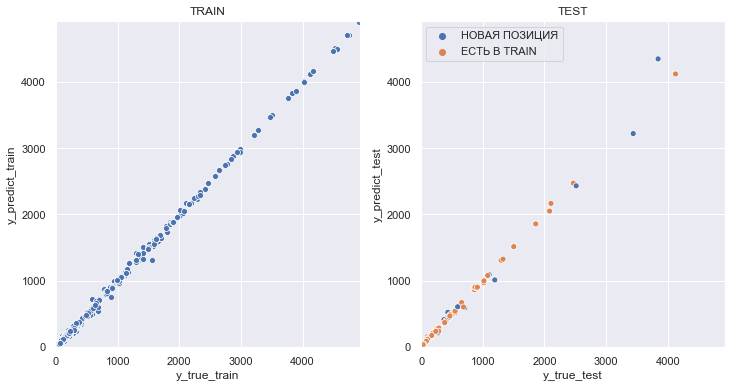

In [53]:
# Выведем графики
true_predict_ratio(y_train, model_lgbm.predict(X_ord_st_train), 
                       y_eval, model_lgbm.predict(X_ord_st_eval), hue = hue_for_eval, xy_max = None)

metrics(y_train, model_lgbm.predict(X_ord_st_train))
metrics(y_eval, model_lgbm.predict(X_ord_st_eval))

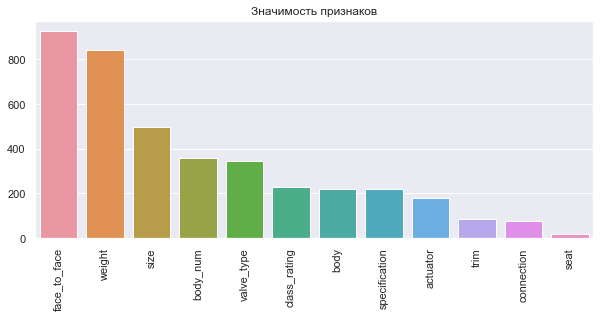

In [54]:
# визуализация важности признаков
importance_visualisation(model_lgbm, X_ord.columns)

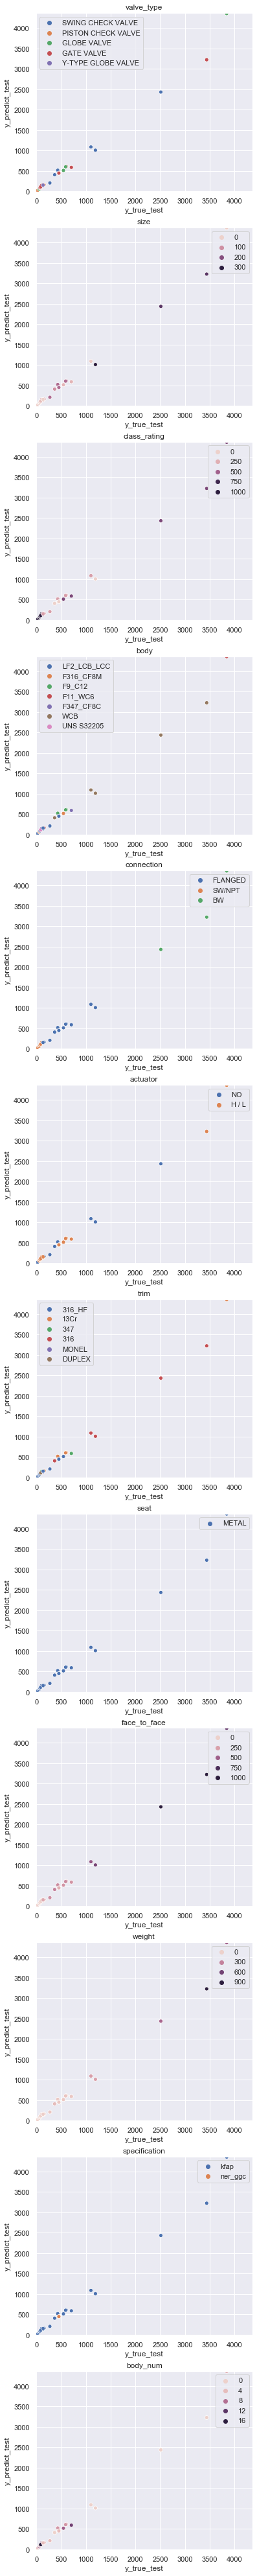

In [55]:
# визуализация только новых позиций, которых нет в обучающей выборке
true_predict_visual_uniq(y_eval_uniq, 
                          model_lgbm.predict(X_ord_st_eval_uniq), X_eval_uniq)

In [56]:
# занесем полученные предсказания в исходную таблицу и сравним с реальными значениями
analys_spec = total_spec.copy()
analys_spec['predict_price'] = model_lgbm.predict(X_ord_st)

# функция для вычисления mape 
def mape(y_true, y_predict):
  return 100. * (y_true - y_predict) / y_true

analys_spec['mape'] = mape(analys_spec['usd_unit_price'], analys_spec['predict_price'] )

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


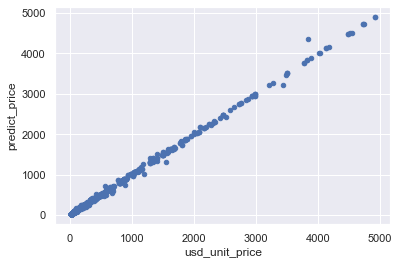

In [57]:
# анализ предсказаний по всему датасету
analys_spec.plot(x = 'usd_unit_price', y = 'predict_price', kind = 'scatter')

In [58]:
analys_spec.query('abs(mape) > 40').drop_duplicates().sort_values('mape', ascending = False)

,valve_type,size,class_rating,body,connection,actuator,trim,seat,face_to_face,weight,specification,body_num,usd_unit_price,predict_price,mape
901,PISTON CHECK VALVE,25,800,F347_CF8C,SW/NPT,NO,347,METAL,127,3.6,kfap,11,82.0,115.394050,-40.724451
1482,GATE VALVE,25,800,F347_CF8C,SW/NPT,H / L,347,METAL,127,3.0,kfap,11,105.0,151.361618,-44.153921
1335,SWING CHECK VALVE,25,150,LF2_LCB_LCC,FLANGED,NO,316_HF,METAL,127,5.3,noz,4,100.0,159.674541,-59.674541


Видим, что самый худший случай - предсказание цены ниже реальной на 46%.  Соответственно можно взять для всех предсказаний коэффициент запаса 1.46.  Это нормально, т.к. модель на данном этапе планируется использовать для расчета предварительных бюджетных цен.   Также с увеличением количества данных и числа моделей точность будет увеличиваться.  В скриптах к данному проекту реализуется использование нескольких моделей полученных из RandomSearch, а предсказанием является СРЕДНЕЕ значение от суммы предсказаний всех моделей